In [1]:
import os
os.chdir('../')
from python_code import gibbs_sampler as gs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
from itertools import combinations
import pymc3 as pm

In [2]:
df = pd.read_csv('../data/mathtest.csv')
df.columns = ['group', 'values']

In [3]:
gibbs = gs.GibbsSampler(df, n_iter=5000, burn=100)

In [4]:
gibbs.fit()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 766.89it/s]


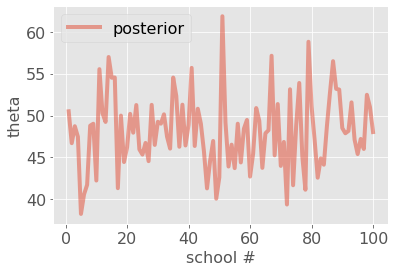

In [5]:
group = df.groupby('group')
plt.plot(np.unique(df['group']),gibbs.traces['theta'].mean(axis=0),alpha=.5, label='posterior')
plt.legend()
plt.xlabel('school #', fontsize=16)
plt.ylabel('theta', fontsize=16);

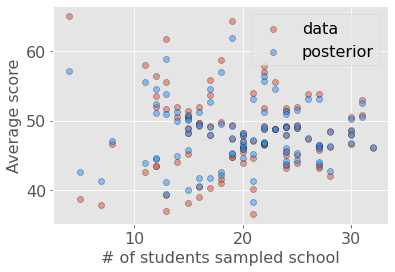

In [16]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='data');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

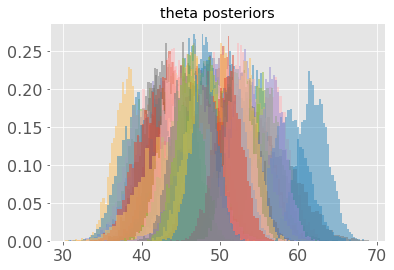

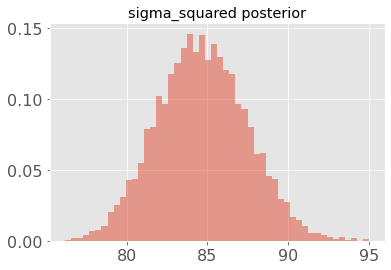

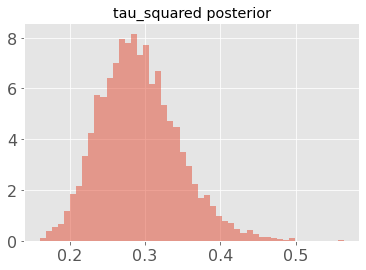

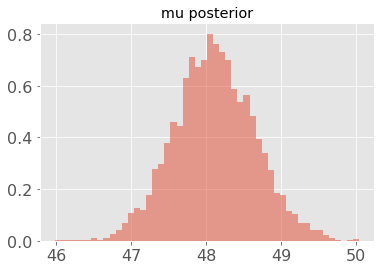

<Figure size 432x288 with 0 Axes>

In [17]:
gibbs.plot_all_posteriors();

In [25]:
group_means = gibbs.traces['mu'].mean()
k_i = np.abs(( gibbs.traces['theta'] - group_means)/group_means).mean(axis=0)

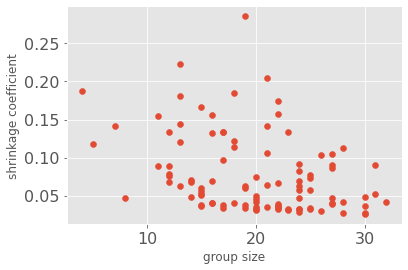

In [26]:
plt.scatter(group.size(), k_i)
plt.xlabel('group size')
plt.ylabel('shrinkage coefficient');

In [10]:
mu = gibbs.traces['mu'].mean()
cov_schools = np.zeros(gibbs.P)
for school in range(gibbs.P):
    all_idx = list(range(gibbs.n_i[school]))
    combs = list(combinations(all_idx, 2))
    combs_not_identical = [comb for comb in combs if combs[0] != combs[1]]
    rows = df[df['group'] == school + 1].reset_index()['values']
    terms = []
    for comb in combs_not_identical:
        terms.append((rows.iloc[comb[0]]-mu) * (rows.iloc[comb[1]]-mu))
    cov_schools[school] = np.mean(terms)

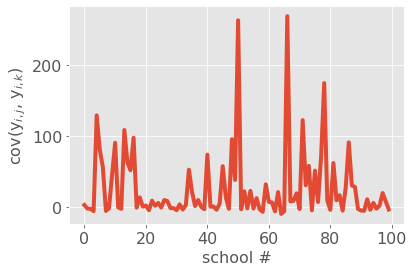

In [11]:
plt.plot(cov_schools)
plt.xlabel('school #', fontsize=16)
plt.ylabel('cov(y$_{i,j}$, y$_{i,k}$)', fontsize=16);

In [12]:
all_idx = list(range(gibbs.P))
combs = list(combinations(all_idx, 2))
combs_not_identical = [comb for comb in combs if combs[0] != combs[1]]
terms = []
for comb in combs_not_identical:
    terms.append((cov_schools[comb[0]] - mu)*(cov_schools[comb[0]] - mu))
cov = np.mean(terms)

In [13]:
cov

2734.843977222651

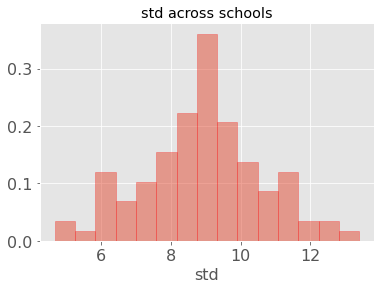

In [14]:
plt.hist(group.std(), alpha=0.5, edgecolor='red', bins=15, density=True);
plt.title('std across schools');
plt.xlabel('std', fontsize=16);

### try with pymc

In [15]:
theta_means = []
from tqdm import tqdm
for school in tqdm(range(gibbs.P)):
    data = df[df['group'] == school+1]
    traces = {'sigma': np.zeros(2000),
                       'tau': np.zeros(2000),
                       'mu': np.zeros(2000),
                       'theta': np.zeros(2000)}
    
    with pm.Model() as model:
        sigma = pm.Normal('sigma',mu=1e-6, sigma=1e3)
        mu = pm.Normal('mu',mu=1e-6, sigma=1e3)
        tau = pm.InverseGamma('tau',0.5,0.5)
        theta = pm.Normal('theta', mu=mu, sd = tau*sigma)
        y = pm.Normal('y', mu=theta, sd=sigma, observed=data['values'])
        try:
            trace = pm.sample(2000, tune = 1000, chains=2,cores=1, return_inferencedata=False)
            theta_means.append(trace.get_values('theta').mean())
        except:
             theta_means.append(None)
             


  0%|                                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 762 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4734711129991567, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1018 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
  1%|█▊                                                                                                                                                                                         | 1/100 [00:09<16:08,  9.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 556 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6015074885677102, but should be close to 0.8. Try to increase the number of tuning steps.
There were 922 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6584801877286041, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  2%|███▋                                                                                                                                                                                       | 2/100 [00:15<12:14,  7.50s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 689 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4810264627142422, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5561304155200522, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  3%|█████▌                                                                                                                                                                                     | 3/100 [00:21<10:47,  6.67s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 948 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4254987445790501, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1783 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4980993101933493, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
  4%|███████▍                                                                                                                                                                                   | 4/100 [00:27<10:02,  6.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6905277496167098, but should be close to 0.8. Try to increase the number of tuning steps.
There were 711 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6554899801164457, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  5%|█████████▎                                                                                                                                                                                 | 5/100 [00:33<09:47,  6.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 498 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6140778212567782, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2323 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0458964562889506, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
  6%|███████████▏                                                                                                                                                                               | 6/100 [00:38<09:11,  5.86s/it]Auto-assigning NUTS sample

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 433 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6724112182214984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5013245389080468, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  7%|█████████████                                                                                                                                                                              | 7/100 [00:44<09:02,  5.83s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5864986845572453, but should be close to 0.8. Try to increase the number of tuning steps.
There were 889 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6466833068887424, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  8%|██████████████▉                                                                                                                                                                            | 8/100 [00:49<08:48,  5.74s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
There were 706 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6593134700955683, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  9%|████████████████▊                                                                                                                                                                          | 9/100 [00:55<08:54,  5.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
There were 528 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5801986829672152, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
 10%|██████████████████▌                                                                                                                                                                       | 10/100 [00:59<07:52,  5

Sampling 1 chain for 234 tune and 0 draw iterations (234 + 0 draws total) took 0 seconds.
No posterior samples. Unable to run convergence checks
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_24436/3250079254.py:18: RuntimeWarning: Mean of empty slice.
  theta_means.append(trace.get_values('theta').mean())
 13%|████████████████████████▏                                                                                                                                                                 | 13/100 [01:03<07:01,  4.85s/it]


KeyboardInterrupt: 

In [ ]:
gibbs_means = gibbs.traces['theta'].mean(axis=0)
plt.scatter(theta_means, gibbs_means)

In [ ]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='prior');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.scatter(group.size(), theta_means, color='green', alpha=.5, edgecolor='black', label='posterior');

plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

In [ ]:
df.groupby('group').size()